In [1]:
import networkx as nx
from networkx.algorithms import bipartite

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import random
import copy
import pandas as pd

import biSBM as bm

# Kernighan-Lin inference
from engines.kl import *
from biSBM.ioutils import get_types

# MCMC inference
from biSBM.ioutils import get_edgelist, get_types
from biSBM.optimalks import *
from engines.mcmc import *
from biSBM.painter import *

# Louvain clustering
import community as community_louvain

# Import copy
import copy # for copy.deepcopy()

%matplotlib inline

In [2]:
fname3 = 'sup.txt'

dfHSDN = pd.read_csv(fname3, sep = '\t')
dfHSDN

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551
2,"Aging, Premature",HIV Infections,3,10.393654
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654
4,"Aging, Premature",Breast Neoplasms,1,3.464551
...,...,...,...,...
147973,Hirsutism,Tobacco Use Disorder,1,2.483722
147974,Hirsutism,Radius Fractures,1,2.483722
147975,Hirsutism,Burns,1,2.483722
147976,Hirsutism,Colles' Fracture,1,2.483722


In [3]:
# Isolate Symptom and Disease term
dfHSDN = dfHSDN[dfHSDN["PubMed occurrence"] >= 150] # Popularity filter, set to 150 for testing
dfHSDN = dfHSDN[dfHSDN["MeSH Symptom Term"]!=dfHSDN["MeSH Disease Term"]]
dfHSDNEdges = dfHSDN.reindex(columns=["MeSH Symptom Term","MeSH Disease Term"])
dfHSDNEdges

,MeSH Symptom Term,MeSH Disease Term
668,Fever,Bacterial Infections
669,Fever,Bacteremia
816,Fever,Staphylococcal Infections
837,Fever,Infection
869,Fever,Sepsis
...,...,...
147273,"Urinary Incontinence, Stress",Postoperative Complications
147461,Virilism,Ovarian Neoplasms
147530,Virilism,"Adrenal Hyperplasia, Congenital"
147641,Hirsutism,Polycystic Ovary Syndrome


In [4]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

part0 = dfHSDNEdges['MeSH Symptom Term'].unique()
part1 = dfHSDNEdges['MeSH Disease Term'].unique()
comm = intersection(part0, part1)
dfHSDNEdges = dfHSDNEdges[~dfHSDNEdges['MeSH Symptom Term'].isin(comm)]
dfHSDNEdges_ = dfHSDNEdges.drop_duplicates(subset=["MeSH Symptom Term","MeSH Disease Term"], keep=False)
listSymptomDiseaseJoin = list(dfHSDNEdges_.to_records(index = False))

dfHSDNEdges_

,MeSH Symptom Term,MeSH Disease Term
668,Fever,Bacterial Infections
669,Fever,Bacteremia
816,Fever,Staphylococcal Infections
837,Fever,Infection
869,Fever,Sepsis
...,...,...
147273,"Urinary Incontinence, Stress",Postoperative Complications
147461,Virilism,Ovarian Neoplasms
147530,Virilism,"Adrenal Hyperplasia, Congenital"
147641,Hirsutism,Polycystic Ovary Syndrome


In [5]:
GHSDNBipartite = nx.Graph()
GHSDNBipartite.add_nodes_from(part0, bipartite = 0)
GHSDNBipartite.add_nodes_from(part1, bipartite = 1)
GHSDNBipartite.add_edges_from(listSymptomDiseaseJoin)
components = sorted(nx.connected_components(GHSDNBipartite), key=len, reverse=True)
largestComponent = components[0]
GHSDNBipartiteII = GHSDNBipartite.subgraph(largestComponent)

symptomNodes, diseaseNodes = bipartite.sets(GHSDNBipartiteII)

fname = 'HSDN.edgelist'
GHSDN_intLabel = nx.convert_node_labels_to_integers(GHSDNBipartiteII)
print('bipartite? : ' + str(nx.is_bipartite(GHSDN_intLabel)))
n1 = len(symptomNodes)
n2 = len(diseaseNodes)

nx.write_edgelist(GHSDN_intLabel, path = fname, delimiter = '\t')
with open(fname, 'r') as f:
    lines = f.readlines()
lines = [line[:-(4)] + '\n' for line in lines]
with open(fname, 'w') as f:
    f.writelines(lines)

bipartite? : True


In [6]:
kl = KL(f_engine="engines/bipartiteSBM-KL/biSBM",
        n_sweeps=2,                                        # Note that this will generate <n_sweeps> output sub-folders in <f_kl_output>
        is_parallel=True,
        n_cores=4,
        kl_edgelist_delimiter="\t",                        # [KL] due to the KL code accepts 1-indexed nodes by default, we used the delimiter to transform our 0-indexed input.
        kl_steps=4,                                        # [KL] the number of random initializations (see the README_cplusplus.txt file)
        kl_itertimes=1,                                    # [KL] the number of KL runs (within each <outputFOLDER>) for returning an optimal result
        f_kl_output="engines/bipartiteSBM-KL/f_kl_output"  # [KL] path to the KL output dir; recommended to be in the same folder as the binary
    )

fname = 'HSDN.edgelist'
GHSDN_intLabel = nx.convert_node_labels_to_integers(GHSDNBipartiteII)
n1 = len(symptomNodes)
n2 = len(diseaseNodes)

nx.write_edgelist(GHSDN_intLabel, path = fname, delimiter = '\t')
with open(fname, 'r') as f:
    lines = f.readlines()
lines = [line[:-(4)] + '\n' for line in lines]
with open(fname, 'w') as f:
    f.writelines(lines)

kl.prepare_engine("HSDN.edgelist", n1, n2, 5, 5, delimiter = '\t')

edgelist = get_edgelist("HSDN.edgelist", delimiter = "\t")
types = kl.gen_types(n1, n2)

oks = OptimalKs(kl, edgelist, types)
oks.set_params(init_ka=7, init_kb=7, i_0=0.1)
oks.minimize_bisbm_dl()
oks.summary()

{'algm_args': {'init_ka': 7, 'init_kb': 7, 'i_0': 0.1},
 'na': 78,
 'nb': 228,
 'e': 394,
 'avg_k': 2.5751633986928106,
 'mdl': 1724.6635298245042,
 'ka': 2,
 'kb': 2,
 'dl': {'adjacency': 1088.9569155352387,
  'partition': 154.24429026966112,
  'degree': 465.3098472319897,
  'edges': 16.152476787614432}}

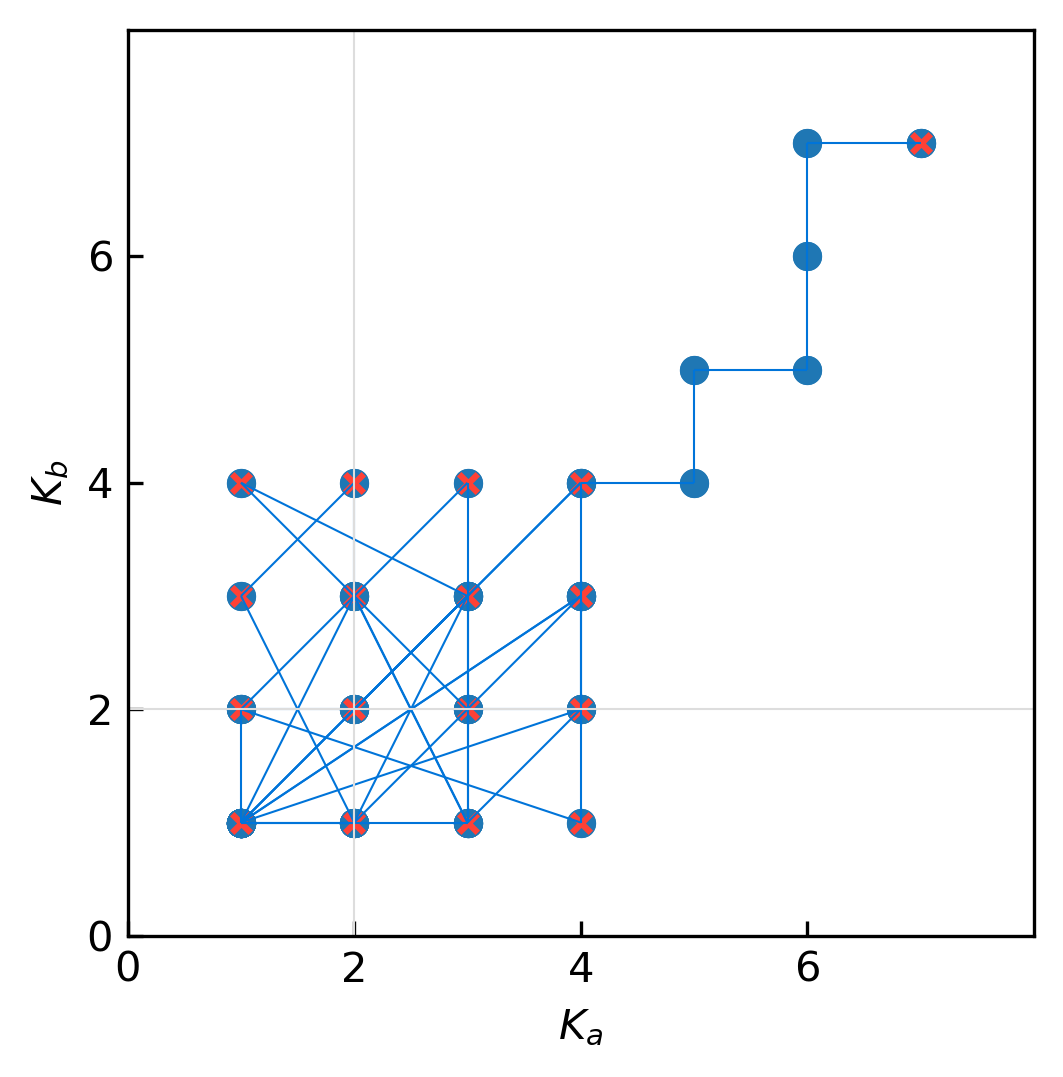

In [7]:
paint_trace(oks)

In [8]:
mcmc = MCMC(f_engine="engines/bipartiteSBM-MCMC/bin/mcmc")
fname = 'HSDN.edgelist'
n1 = len(symptomNodes)
n2 = len(diseaseNodes)
GHSDN_intLabel = nx.convert_node_labels_to_integers(GHSDNBipartiteII)

nx.write_edgelist(GHSDN_intLabel, path = fname)
with open(fname, 'r') as f:
    lines = f.readlines()
lines = [line[:-(4)] + '\n' for line in lines]
with open(fname, 'w') as f:
    f.writelines(lines)

mcmc.prepare_engine('HSDN.edgelist', n1, n2, 5, 5)
edgelist = get_edgelist('HSDN.edgelist')
types = mcmc.gen_types(n1, n2)
oks = OptimalKs(mcmc, edgelist, types)
oks.minimize_bisbm_dl()
oks.summary()

{'algm_args': {'init_ka': 14, 'init_kb': 15, 'i_0': 0.009055945453628983},
 'na': 78,
 'nb': 228,
 'e': 394,
 'avg_k': 2.5751633986928106,
 'mdl': 1703.710563246614,
 'ka': 3,
 'kb': 3,
 'dl': {'adjacency': 1056.9791990937174,
  'partition': 175.10004093412178,
  'degree': 434.33439837946975,
  'edges': 37.29692483930489}}

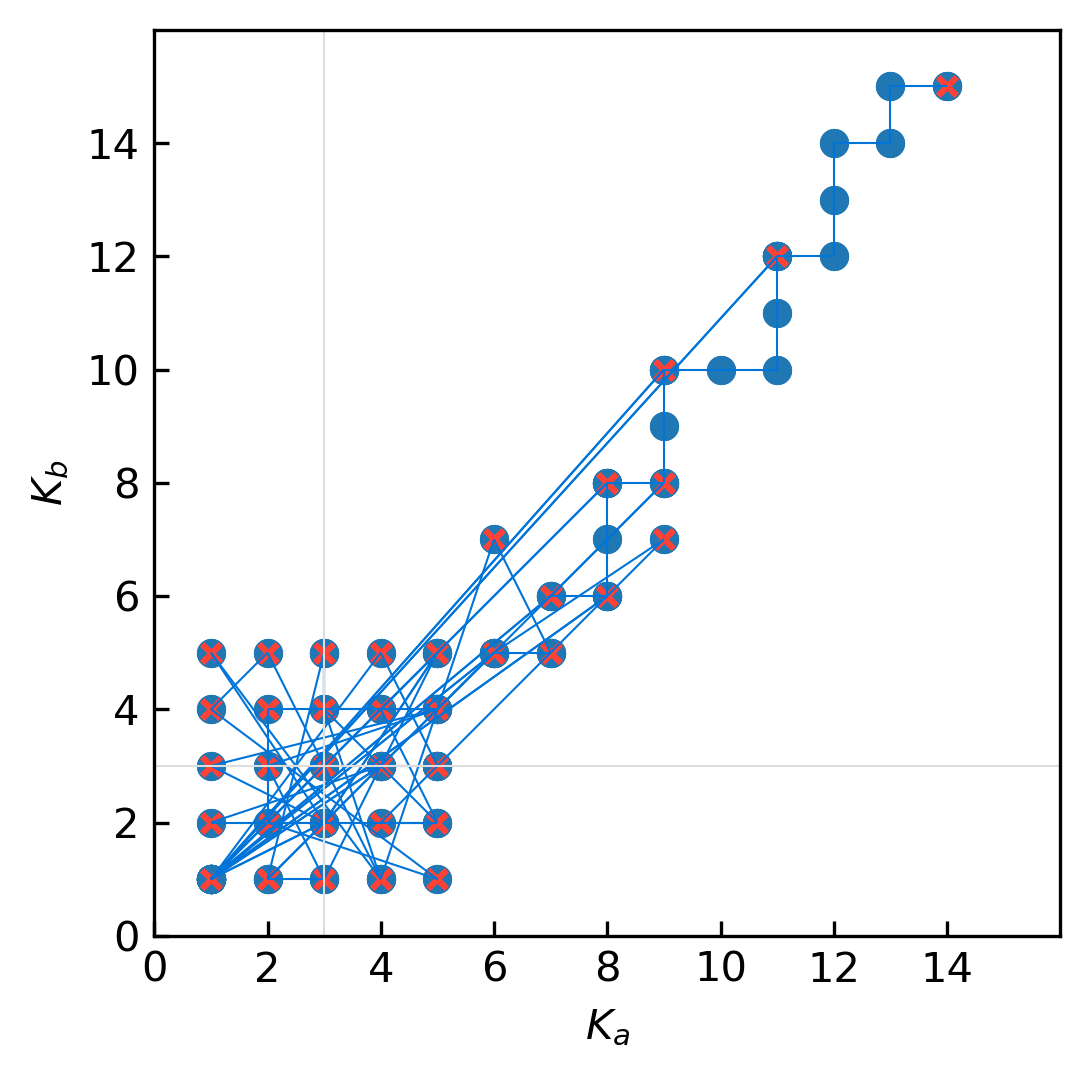

In [9]:
paint_trace(oks)